# Upper-Confidence-Bound Action Selection

The e-greedy agent explore with probabilities which doesnt depend on the value function.
The UCB tries to estimate the value function and variance for each action. 
Then action is selected based on both value and variance.

The formula to select action:

$$ A_t = argmax_{a} \left[ Q_t(a) + c \sqrt{ \frac{log(t)}{N_t(a)} } \right] $$

Where:
  * $\sqrt{ \frac{log(t)}{N_t(a)} }$ - Is variance (uncertainty) of action value
  * $N_t(a)$ - How many times this action was selected
  * c - controls the degree of exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4

## Helper functions for environment

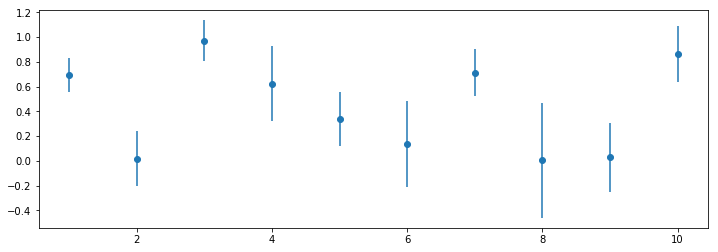

In [2]:
class Bandit:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def roll(self):
        return np.random.normal(self.mean, self.std)
    

def random_bandits(k, max_mean=1.0, max_std=0.1):
    bs = []
    for _ in range(k):
        mean = np.random.uniform(0.0, max_mean)
        std = np.random.uniform(0.0, max_std)
        bs.append(Bandit(mean, std))
    return bs
    
    
def plot_bandits(bs):
    x = np.array(np.linspace(1, k, k))
    y = [x.mean for x in bandits]
    e = [x.std for x in bandits]
    plt.errorbar(x, y, e, linestyle='None', marker='o')
    plt.show()    
    
    
def moving_average(xs, n=100):
    cs = np.cumsum(xs, dtype=float)
    cs[n:] = cs[n:] - cs[:-n]
    return cs[n - 1:] / n    


# Sample bandits
k = 10
bandits = random_bandits(k, max_std=0.5)
plot_bandits(bandits)

## Helper functions for agent

In [3]:
class Agent:
    
    def choose_action(self):
        return 0
    
    def learn(self, action, reward):
        pass
    
    
def evaluate(agent, bandits, num_episodes=1000, window=10):
    rewards = []
    for episode in range(num_episodes):
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            agent.learn(a, reward)
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, window)

## GreedyAgent

As a baseline

In [13]:
class GreedyAgent:
    
    def __init__(self, k=10, epsilon=0.1, alpha=0.1):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros(k)
        
    def choose_action(self):
        """Select random bandit with probability epsilon.
           Or best bandit otherwise
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.k))
        else:
            return np.argmax(self.Q)
        
    def learn(self, action, reward):
        self.Q[action] = self.Q[action] + self.alpha*(reward-self.Q[action])

## UCB Agent

In [11]:
class UCBAgent(Agent):
    
    def __init__(self, k, c=2.0):
        self.k = k
        self.c = c
        self.Q = np.zeros(k)
        self.counters = np.zeros(k)
        
    def choose_action(self):
        if np.min(self.counters) == 0:
            return np.argmin(self.counters)
        else:
            t = np.sum(self.counters)
            var = self.c * np.sqrt(np.log(t)/self.counters)
            return np.argmax(self.Q + var)
        
    def learn(self, action, reward):
        n = self.counters[action]
        self.Q[action] = (self.Q[action]*n + reward)/(n+1)
        self.counters[action] += 1

## Compare agents

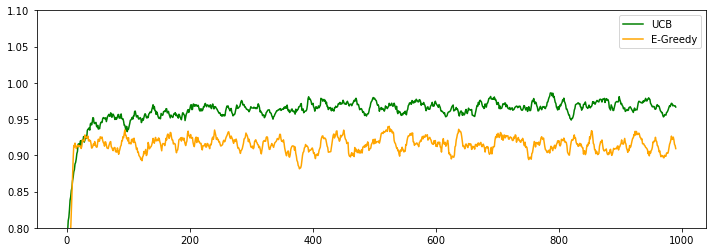

In [15]:
plt.plot(evaluate(UCBAgent(k), bandits), color='green', label='UCB')
plt.plot(evaluate(GreedyAgent(k), bandits), color='orange', label='E-Greedy')
plt.ylim([0.8, 1.1])
plt.legend()
plt.show()